In [1]:
# Environment setup and imports
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, log_loss, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import yaml
from typing import List, Dict

ROOT = Path().resolve().parents[2]  # project root
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.data.real_data import CriteoDataset, SyntheticCriteoDataset
from src.models.esmm import ESMM
from src.models.gbdt_proto import MTGBDT
from src.models.stgbdt import STGBDTBaseline
from src.models.utils import add_cvr_labels


def evaluate_predictions(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """Compute CTR/CTCVR/CVR AUC and LogLoss."""
    eps = 1e-8
    y_click = y_true[:, 0]
    y_conv = y_true[:, 1]
    y_ctcvr = y_click * y_conv

    pred_ctr = np.clip(y_pred[:, 0], eps, 1 - eps)
    pred_ctcvr = np.clip(y_pred[:, 1], eps, 1 - eps)
    pred_cvr = np.clip(y_pred[:, 2], eps, 1 - eps)

    metrics = {}
    metrics["auc_ctr"] = roc_auc_score(y_click, pred_ctr)
    metrics["logloss_ctr"] = log_loss(y_click, pred_ctr)
    precision, recall, thresholds = precision_recall_curve(y_click, pred_ctr)
    metrics["pr_auc_ctr"] = auc(recall, precision)

    metrics["auc_ctcvr"] = roc_auc_score(y_ctcvr, pred_ctcvr)
    metrics["logloss_ctcvr"] = log_loss(y_ctcvr, pred_ctcvr)
    precision, recall, thresholds = precision_recall_curve(y_ctcvr, pred_ctcvr)
    metrics["pr_auc_ctcvr"] = auc(recall, precision)

    click_mask = y_click == 1
    if np.sum(click_mask) > 1 and np.unique(y_conv[click_mask]).size > 1:
        metrics["auc_cvr"] = roc_auc_score(y_conv[click_mask], pred_cvr[click_mask])
        metrics["logloss_cvr"] = log_loss(y_conv[click_mask], pred_cvr[click_mask])
        precision, recall, thresholds = precision_recall_curve(y_conv[click_mask], pred_cvr[click_mask])
        metrics["pr_auc_cvr"] = auc(recall, precision)
    else:
        metrics["auc_cvr"] = np.nan
        metrics["logloss_cvr"] = np.nan
    return metrics

c:\Users\oiwal\products\MT_AI_GBDT\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 分析: ノードにおける分岐時情報利得の調査

In [5]:
# Helper: traverse MTGBDT trees and capture split logs for each split node
from typing import Dict, List


def _collect_split_logs_from_tree(tree, stage: str, tree_index: int) -> List[Dict]:
    records: List[Dict] = []

    def walk(node):
        if node is None:
            return
        if not node.is_leaf:
            left_samples = node.left.n_samples if node.left is not None else 0
            right_samples = node.right.n_samples if node.right is not None else 0
            records.append(
                {
                    "stage": stage,
                    "tree_index": tree_index,
                    "node_id": node.node_id,
                    "depth": node.depth,
                    "n_samples": node.n_samples,
                    "left_samples": left_samples,
                    "right_samples": right_samples,
                    "feature_idx": node.feature_idx,
                    "threshold": node.threshold,
                    "information_gain": node.information_gain,
                }
            )
        walk(node.left)
        walk(node.right)

    walk(tree.root)
    return records


In [3]:
# Collect split logs and compute gain statistics for STGBDTBaseline
split_logs: List[Dict] = []


def _append_stage_logs(model, stage: str):
    if model is None:
        print(f"Skipping {stage}: model is None")
        return
    for idx, tree_info in enumerate(model.trees_):
        tree = tree_info.get("tree")
        if tree is None or tree.root is None:
            continue
        split_logs.extend(_collect_split_logs_from_tree(tree, stage=stage, tree_index=idx))

In [6]:
# Multi-run STGBDTBaseline training across sample sizes and split-gain logging
sample_sizes = [5000, 10000, 50000, 100000, 300000]
val_size = 0.1
test_size = 0.2
seed = 42

all_split_logs: List[Dict] = []
all_depth_stats: List[pd.DataFrame] = []
all_size_stats: List[pd.DataFrame] = []

for n_samples in sample_sizes:
    print(f"\n=== Running STGBDTBaseline with sample_size={n_samples} ===")
    dataset = CriteoDataset(sample_size=n_samples)
    try:
        X, y = dataset.get_data(random_state=seed)
        source = "CriteoDataset"
    except Exception:
        synth = SyntheticCriteoDataset(sample_size=n_samples)
        X, y = synth.load_data(random_state=seed)
        source = "SyntheticCriteoDataset"

    X_train, X_tmp, y_train, y_tmp = train_test_split(
        X, y, test_size=test_size + val_size, random_state=seed, stratify=y[:, 0]
    )
    rel_val = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=1 - rel_val, random_state=seed, stratify=y_tmp[:, 0]
    )

    stg_run = STGBDTBaseline(
        n_estimators=10, learning_rate=0.3, max_depth=4, min_samples_split=20, min_samples_leaf=10, random_state=seed
    )
    stg_run.fit(X_train, y_train)

    split_logs: List[Dict] = []

    def _append_stage_logs(model, stage: str):
        if model is None:
            print(f"Skipping {stage}: model is None")
            return
        for idx, tree_info in enumerate(model.trees_):
            tree = tree_info.get("tree")
            if tree is None or tree.root is None:
                continue
            split_logs.extend(_collect_split_logs_from_tree(tree, stage=stage, tree_index=idx))

    _append_stage_logs(stg_run.ctr_model, "ctr")
    _append_stage_logs(stg_run.ctcvr_model, "ctcvr")
    _append_stage_logs(stg_run.conditional_cvr_model, "cvr")

    split_logs_df = pd.DataFrame(split_logs)
    if split_logs_df.empty:
        print("No split logs were collected for this run.")
        continue

    split_logs_df["sample_size"] = n_samples
    all_split_logs.append(split_logs_df)

    depth_stats = (
        split_logs_df.groupby(["sample_size", "stage", "depth"])["information_gain"]
        .agg(["count", "mean", "median", "max"])
        .reset_index()
        .sort_values(["sample_size", "stage", "depth"])
    )
    all_depth_stats.append(depth_stats)

    size_bins = pd.qcut(split_logs_df["n_samples"], q=6, duplicates="drop")
    size_stats = (
        split_logs_df.assign(sample_bin=size_bins)
        .groupby(["sample_size", "stage", "sample_bin"])["information_gain"]
        .agg(["count", "mean", "median", "max"])
        .reset_index()
    )
    all_size_stats.append(size_stats)

    log_dir = ROOT / "logs" / "training"
    log_dir.mkdir(parents=True, exist_ok=True)
    split_log_path = log_dir / f"stgbdt_split_logs_{n_samples}.csv"
    depth_stats_path = log_dir / f"stgbdt_split_gain_by_depth_{n_samples}.csv"
    size_stats_path = log_dir / f"stgbdt_split_gain_by_samples_{n_samples}.csv"

    split_logs_df.to_csv(split_log_path, index=False)
    depth_stats.to_csv(depth_stats_path, index=False)
    size_stats.to_csv(size_stats_path, index=False)

    print(f"Stored {len(split_logs_df)} split records for sample_size={n_samples} to {split_log_path}")
    display(depth_stats.head())

if all_split_logs:
    combined_logs = pd.concat(all_split_logs, ignore_index=True)
    combined_depth = pd.concat(all_depth_stats, ignore_index=True)
    combined_size = pd.concat(all_size_stats, ignore_index=True)

    log_dir = ROOT / "logs" / "training"
    log_dir.mkdir(parents=True, exist_ok=True)
    combined_log_path = log_dir / "stgbdt_split_logs_all.csv"
    combined_depth_path = log_dir / "stgbdt_split_gain_by_depth_all.csv"
    combined_size_path = log_dir / "stgbdt_split_gain_by_samples_all.csv"

    combined_logs.to_csv(combined_log_path, index=False)
    combined_depth.to_csv(combined_depth_path, index=False)
    combined_size.to_csv(combined_size_path, index=False)

    print("\n=== Combined outputs ===")
    print(f"All splits: {combined_log_path}")
    print(f"Depth stats: {combined_depth_path}")
    print(f"Sample-bin stats: {combined_size_path}")

    display(combined_depth.groupby(["sample_size", "stage", "depth"])["mean"].head())
else:
    print("No logs were generated across runs.")



=== Running STGBDTBaseline with sample_size=5000 ===
Loading Criteo dataset from C:\Users\oiwal\products\MT_AI_GBDT\src\data\criteo-research-uplift-v2.1.csv.gz...
Loaded 5000 samples with 16 columns
Data shape: X=(5000, 12), y=(5000, 2)
Iteration 1/10, LogLoss: 0.072506, Time: 0.10s
Iteration 10/10, LogLoss: 0.038658, Time: 1.10s
Iteration 1/10, LogLoss: 0.087880, Time: 0.09s
Iteration 10/10, LogLoss: 0.168375, Time: 1.03s
Iteration 1/10, LogLoss: 0.413137, Time: 0.00s
Iteration 10/10, LogLoss: 0.253406, Time: 0.03s
Stored 200 split records for sample_size=5000 to C:\Users\oiwal\products\logs\training\stgbdt_split_logs_5000.csv


C:\Users\oiwal\AppData\Local\Temp\ipykernel_13268\2112509606.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["sample_size", "stage", "sample_bin"])["information_gain"]


,sample_size,stage,depth,count,mean,median,max
0,5000,ctcvr,0,10,0.022676,0.019955,0.057492
1,5000,ctcvr,1,18,0.016645,0.009856,0.103583
2,5000,ctcvr,2,20,0.020442,0.001424,0.226047
3,5000,ctcvr,3,14,0.025824,0.002618,0.221807
4,5000,ctr,0,10,0.012193,0.007401,0.040473



=== Running STGBDTBaseline with sample_size=10000 ===
Loading Criteo dataset from C:\Users\oiwal\products\MT_AI_GBDT\src\data\criteo-research-uplift-v2.1.csv.gz...
Loaded 10000 samples with 16 columns
Data shape: X=(10000, 12), y=(10000, 2)
Iteration 1/10, LogLoss: 0.071356, Time: 0.20s
Iteration 10/10, LogLoss: 0.043039, Time: 2.18s
Iteration 1/10, LogLoss: 0.089621, Time: 0.22s
Iteration 10/10, LogLoss: 0.073513, Time: 2.12s
Iteration 1/10, LogLoss: 0.420701, Time: 0.01s
Iteration 10/10, LogLoss: 0.220719, Time: 0.10s
Stored 287 split records for sample_size=10000 to C:\Users\oiwal\products\logs\training\stgbdt_split_logs_10000.csv


C:\Users\oiwal\AppData\Local\Temp\ipykernel_13268\2112509606.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["sample_size", "stage", "sample_bin"])["information_gain"]


,sample_size,stage,depth,count,mean,median,max
0,10000,ctcvr,0,10,0.042142,0.027796,0.079846
1,10000,ctcvr,1,20,0.017042,0.005389,0.127243
2,10000,ctcvr,2,28,0.049682,0.000454,1.295386
3,10000,ctcvr,3,33,0.006601,0.000366,0.125069
4,10000,ctr,0,10,0.024810,0.019094,0.088874



=== Running STGBDTBaseline with sample_size=50000 ===
Loading Criteo dataset from C:\Users\oiwal\products\MT_AI_GBDT\src\data\criteo-research-uplift-v2.1.csv.gz...
Loaded 50000 samples with 16 columns
Data shape: X=(50000, 12), y=(50000, 2)
Iteration 1/10, LogLoss: 0.083868, Time: 1.07s
Iteration 10/10, LogLoss: 0.063766, Time: 10.85s
Iteration 1/10, LogLoss: 0.066482, Time: 0.99s
Iteration 10/10, LogLoss: 0.044104, Time: 23.34s
Iteration 1/10, LogLoss: 0.441243, Time: 0.17s
Iteration 10/10, LogLoss: 0.356911, Time: 1.84s
Stored 416 split records for sample_size=50000 to C:\Users\oiwal\products\logs\training\stgbdt_split_logs_50000.csv


C:\Users\oiwal\AppData\Local\Temp\ipykernel_13268\2112509606.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["sample_size", "stage", "sample_bin"])["information_gain"]


,sample_size,stage,depth,count,mean,median,max
0,50000,ctcvr,0,10,0.129825,0.110475,0.304332
1,50000,ctcvr,1,20,0.060469,0.022799,0.308243
2,50000,ctcvr,2,39,0.041106,0.001587,0.294809
3,50000,ctcvr,3,72,0.016390,0.000810,0.546887
4,50000,ctr,0,10,0.213396,0.203929,0.428354



=== Running STGBDTBaseline with sample_size=100000 ===
Loading Criteo dataset from C:\Users\oiwal\products\MT_AI_GBDT\src\data\criteo-research-uplift-v2.1.csv.gz...
Loaded 100000 samples with 16 columns
Data shape: X=(100000, 12), y=(100000, 2)
Iteration 1/10, LogLoss: 0.083894, Time: 5.53s
Iteration 10/10, LogLoss: 0.060629, Time: 55.94s
Iteration 1/10, LogLoss: 0.080366, Time: 6.03s
Iteration 10/10, LogLoss: 0.056979, Time: 57.63s
Iteration 1/10, LogLoss: 0.451286, Time: 0.31s
Iteration 10/10, LogLoss: 0.400962, Time: 3.22s
Stored 426 split records for sample_size=100000 to C:\Users\oiwal\products\logs\training\stgbdt_split_logs_100000.csv


C:\Users\oiwal\AppData\Local\Temp\ipykernel_13268\2112509606.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["sample_size", "stage", "sample_bin"])["information_gain"]


,sample_size,stage,depth,count,mean,median,max
0,100000,ctcvr,0,10,0.312670,0.275155,0.620932
1,100000,ctcvr,1,20,0.136374,0.057868,0.377321
2,100000,ctcvr,2,39,0.074050,0.004842,0.797183
3,100000,ctcvr,3,77,0.043188,0.001200,0.446650
4,100000,ctr,0,10,0.480827,0.475416,0.688274



=== Running STGBDTBaseline with sample_size=300000 ===
Loading Criteo dataset from C:\Users\oiwal\products\MT_AI_GBDT\src\data\criteo-research-uplift-v2.1.csv.gz...
Loaded 300000 samples with 16 columns
Data shape: X=(300000, 12), y=(300000, 2)
Iteration 1/10, LogLoss: 0.084707, Time: 16.66s
Iteration 10/10, LogLoss: 0.063180, Time: 148.20s
Iteration 1/10, LogLoss: 0.071880, Time: 16.26s
Iteration 10/10, LogLoss: 0.041342, Time: 163.63s
Iteration 1/10, LogLoss: 0.448154, Time: 0.73s
Iteration 10/10, LogLoss: 0.412868, Time: 6.99s
Stored 431 split records for sample_size=300000 to C:\Users\oiwal\products\logs\training\stgbdt_split_logs_300000.csv


C:\Users\oiwal\AppData\Local\Temp\ipykernel_13268\2112509606.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["sample_size", "stage", "sample_bin"])["information_gain"]


,sample_size,stage,depth,count,mean,median,max
0,300000,ctcvr,0,10,0.577496,0.370222,1.715607
1,300000,ctcvr,1,20,0.281491,0.034473,1.177711
2,300000,ctcvr,2,40,0.161327,0.012976,1.522176
3,300000,ctcvr,3,77,0.097810,0.004605,1.567164
4,300000,ctr,0,10,1.268819,1.247475,2.488610



=== Combined outputs ===
All splits: C:\Users\oiwal\products\logs\training\stgbdt_split_logs_all.csv
Depth stats: C:\Users\oiwal\products\logs\training\stgbdt_split_gain_by_depth_all.csv
Sample-bin stats: C:\Users\oiwal\products\logs\training\stgbdt_split_gain_by_samples_all.csv


0     0.022676
1     0.016645
2     0.020442
3     0.025824
4     0.012193
5     0.003299
6     0.004098
7     0.005252
8     0.001214
9     0.000494
10    0.000190
11    0.042142
12    0.017042
13    0.049682
14    0.006601
15    0.024810
16    0.009532
17    0.006405
18    0.006893
19    0.001628
20    0.000640
21    0.000460
22    0.000378
23    0.129825
24    0.060469
25    0.041106
26    0.016390
27    0.213396
28    0.093128
29    0.067531
30    0.030108
31    0.009099
32    0.001670
33    0.001248
34    0.000949
35    0.312670
36    0.136374
37    0.074050
38    0.043188
39    0.480827
40    0.214960
41    0.050612
42    0.047233
43    0.017597
44    0.005588
45    0.002617
46    0.002815
47    0.577496
48    0.281491
49    0.161327
50    0.097810
51    1.268819
52    0.664557
53    0.290926
54    0.135689
55    0.057696
56    0.018033
57    0.008626
58    0.006579
Name: mean, dtype: float64

Rows: 1760
Sample sizes: [5000, 10000, 50000, 100000, 300000]
  stage  tree_index  node_id  depth  n_samples  left_samples  right_samples  \
0   ctr           0        0      0       3499          3331            168   
1   ctr           0        1      1       3331            27           3304   
2   ctr           0        2      2         27            11             16   
3   ctr           0        5      2       3304          3184            120   
4   ctr           0        6      3       3184           383           2801   

   feature_idx  threshold  information_gain  sample_size  
0            9   1.864452          0.040473         5000  
1            8  -3.211917          0.006089         5000  
2           10   4.185901          0.000330         5000  
3            9   0.120802          0.002501         5000  
4            8  -0.111955          0.001656         5000  

Mean gain by sample size and depth (first rows):
    sample_size  stage  depth  count      mean    median   

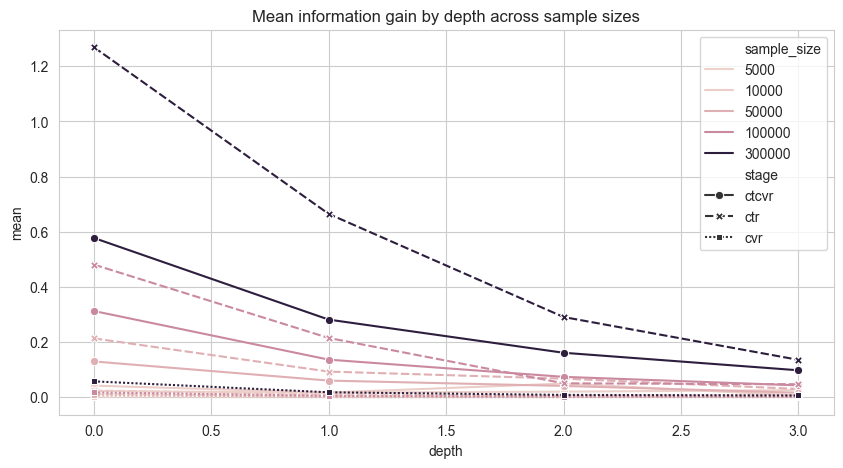

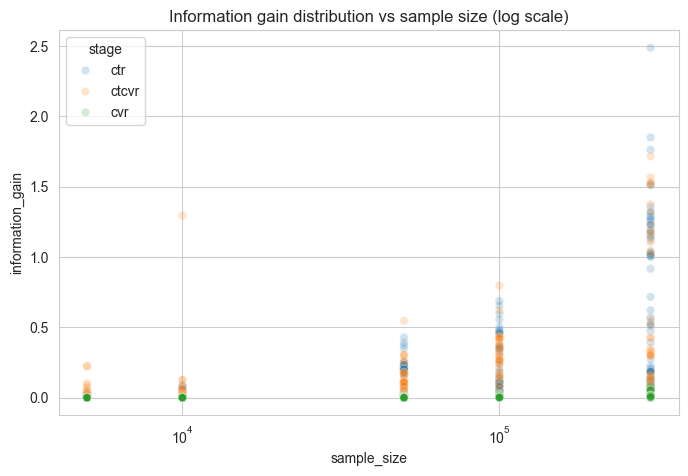

In [7]:
# Analyze split-gain trends vs. sample size and tree depth
log_dir = ROOT / "logs" / "training"
combined_log_path = log_dir / "stgbdt_split_logs_all.csv"

if not combined_log_path.exists():
    raise FileNotFoundError(f"Combined log not found: {combined_log_path}. Run the multi-run cell first.")

logs = pd.read_csv(combined_log_path)

# Basic summaries
print("Rows:", len(logs))
print("Sample sizes:", sorted(logs["sample_size"].unique().tolist()))
print(logs.head())

# Mean gain by sample size and depth
mean_by_size_depth = (
    logs.groupby(["sample_size", "stage", "depth"])['information_gain']
    .agg(['count', 'mean', 'median', 'max'])
    .reset_index()
    .sort_values(["sample_size", "stage", "depth"])
)
print("\nMean gain by sample size and depth (first rows):")
print(mean_by_size_depth.head(20))

# Depth-wise overall trend per sample size
mean_by_size = (
    logs.groupby(["sample_size", "stage"])['information_gain']
    .agg(['count', 'mean', 'median', 'max'])
    .reset_index()
    .sort_values(["sample_size", "stage"])
)
print("\nMean gain by sample size (all depths pooled):")
print(mean_by_size)

# Correlation / monotonic check: gain vs depth per sample size
corrs = []
for n in sorted(logs["sample_size"].unique()):
    sub = logs[logs["sample_size"] == n]
    corr = sub[['depth', 'information_gain']].corr().iloc[0, 1]
    corrs.append({"sample_size": n, "depth_gain_corr": corr})
corrs_df = pd.DataFrame(corrs)
print("\nDepth vs gain correlation per sample size:")
print(corrs_df)

# Optional quick plots (requires matplotlib inline)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_style("whitegrid")

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=mean_by_size_depth, x="depth", y="mean", hue="sample_size", style="stage", markers=True)
    plt.title("Mean information gain by depth across sample sizes")
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=logs, x="sample_size", y="information_gain", hue="stage", alpha=0.2)
    plt.xscale("log")
    plt.title("Information gain distribution vs sample size (log scale)")
    plt.show()
except Exception as e:
    print(f"Plotting skipped: {e}")


## 提案手法: 切り替わり記録

In [4]:
# Configure paths and parameter
def get_data(train_size: int, test_size: int, val_size: int):
    sample_size = train_size + test_size + val_size
    seed = 42
    output_csv = ROOT / "reports" / "tables" / "criteo_experiment_notebook.csv"
    results = []

    # Load Criteo or Synthetic dataset
    data_path = ROOT / "src" / "data" / "criteo-research-uplift-v2.1.csv.gz"
    dataset = CriteoDataset(sample_size=sample_size)
    try:
        X, y = dataset.get_data(random_state=seed)
        source = "CriteoDataset"
    except Exception:
        synth = SyntheticCriteoDataset(sample_size=sample_size)
        X, y = synth.load_data(random_state=seed)
        source = "SyntheticCriteoDataset"

    X_shape, y_shape = X.shape, y.shape

    # Random permutation without overlap
    rng = np.random.default_rng(seed)
    perm = rng.permutation(X.shape[0])
    if len(perm) < sample_size:
        raise ValueError(f"Requested {sample_size} samples but only {len(perm)} available")

    train_idx = perm[:train_size]
    val_idx = perm[train_size:train_size + val_size]
    test_idx = perm[train_size + val_size:train_size + val_size + test_size]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [3]:
train_size=100000
val_size=30000
test_size=100000

X_train, X_val, X_test, y_train, y_val, y_test = get_data(train_size=train_size, val_size=val_size, test_size=test_size)
results = []

Loading Criteo dataset from C:\Users\oiwal\products\MT_AI_GBDT\src\data\criteo-research-uplift-v2.1.csv.gz...
Loaded 230000 samples with 16 columns
Data shape: X=(230000, 12), y=(230000, 2)


In [7]:
def do_propose(X_train, X_val, X_test, y_train, y_val, y_test, delta, results):
    mtgbdt = MTGBDT(
        n_estimators=20,
        learning_rate=0.1,
        max_depth=3,
        n_tasks=3,
        loss="logloss",
        weighting_strategy="ctcvr_subctr_de_norm_gain",
        delta=delta,
    )
    mtgbdt.fit(X_train, y_train)
    stats = getattr(mtgbdt, "training_stats_", {})

    mtgbdt_pred = mtgbdt.predict_proba(X_test)
    mtgbdt_metrics = evaluate_predictions(y_test, mtgbdt_pred)
    mtgbdt_metrics.update(
        {
            "model": "propose",
            "train_size": train_size,
            "propose_switches": stats.get("propose_switches"),
            "propose_split_calls": stats.get("propose_split_calls"),
            "delta": delta,
                    }
    )
    print(
        f"propose_switches: {stats.get('propose_switches', 'N/A')} / "
        f"propose_split_calls: {stats.get('propose_split_calls', 'N/A')}"
    )
    results.append(mtgbdt_metrics)

    split_logs = stats.get("split_logs", [])
    return mtgbdt_metrics, split_logs

In [11]:
results = []
all_split_logs = []

for train_size in [10000, 50000, 100000, 200000]:
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(train_size=train_size, val_size=int(train_size*0.1), test_size=100000)
    for delta in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 3.0, 5.0, 10, 30]:
        metrics, split_logs = do_propose(X_train, X_val, X_test, y_train, y_val, y_test, delta, results)
        if split_logs:
            all_split_logs.extend(split_logs)
# Metrics summary
df_results = pd.DataFrame(results)

# Combine training-time split logs
if all_split_logs:
    combined_logs_df = pd.DataFrame(all_split_logs)
else:
    combined_logs_df = pd.DataFrame()

df_results, combined_logs_df.head()

Loading Criteo dataset from C:\Users\oiwal\products\MT_AI_GBDT\src\data\criteo-research-uplift-v2.1.csv.gz...
Loaded 111000 samples with 16 columns
Data shape: X=(111000, 12), y=(111000, 2)
Iteration 1/20, LogLoss: 0.064484, Time: 0.22s
Iteration 10/20, LogLoss: 0.048690, Time: 1.88s
Iteration 20/20, LogLoss: 0.041510, Time: 3.65s
propose_switches: 10 / propose_split_calls: 278
Iteration 1/20, LogLoss: 0.064484, Time: 0.18s
Iteration 10/20, LogLoss: 0.048688, Time: 1.87s
Iteration 20/20, LogLoss: 0.041508, Time: 3.73s
propose_switches: 12 / propose_split_calls: 279
Iteration 1/20, LogLoss: 0.064484, Time: 0.19s
Iteration 10/20, LogLoss: 0.048672, Time: 1.85s
Iteration 20/20, LogLoss: 0.041491, Time: 3.77s
propose_switches: 14 / propose_split_calls: 280
Iteration 1/20, LogLoss: 0.064484, Time: 0.17s
Iteration 10/20, LogLoss: 0.048672, Time: 1.83s
Iteration 20/20, LogLoss: 0.041491, Time: 3.68s
propose_switches: 17 / propose_split_calls: 280
Iteration 1/20, LogLoss: 0.064484, Time: 0.18s

(     auc_ctr  logloss_ctr  pr_auc_ctr  auc_ctcvr  logloss_ctcvr  pr_auc_ctcvr  \
 0   0.938866     0.076872    0.383942   0.909184       0.044234      0.150905   
 1   0.938867     0.076857    0.384189   0.909190       0.044251      0.150858   
 2   0.938868     0.076855    0.384146   0.909190       0.044253      0.150868   
 3   0.938868     0.076855    0.384146   0.909190       0.044253      0.150868   
 4   0.938868     0.076855    0.384146   0.909190       0.044253      0.150868   
 5   0.938868     0.076855    0.384146   0.909190       0.044253      0.150868   
 6   0.938936     0.076795    0.385257   0.909190       0.044250      0.150882   
 7   0.938769     0.071808    0.411568   0.911302       0.034255      0.177205   
 8   0.940015     0.071185    0.420181   0.911230       0.034191      0.177380   
 9   0.951634     0.068284    0.441744   0.910971       0.033484      0.178894   
 10  0.954695     0.070344    0.405078   0.915113       0.033606      0.167592   
 11  0.953995   

In [14]:
df_results.to_csv("../../reports/tables/260111_criteo_propose_experiment_results.csv", index=False)
combined_logs_df.to_csv("../../reports/tables/260111_criteo_propose_experiment_split_logs.csv", index=False)

In [2]:
df_results = pd.read_csv("../../reports/tables/260111_criteo_propose_experiment_results.csv")
combined_logs_df = pd.read_csv("../../reports/tables/260111_criteo_propose_experiment_split_logs.csv")

In [3]:
display(df_results.head(10))
display(combined_logs_df.head(10))

,auc_ctr,logloss_ctr,pr_auc_ctr,auc_ctcvr,logloss_ctcvr,pr_auc_ctcvr,auc_cvr,logloss_cvr,pr_auc_cvr,model,train_size,propose_switches,propose_split_calls,delta
0,0.938866,0.076872,0.383942,0.909184,0.044234,0.150905,0.703144,0.450198,0.395727,propose,10000,10,278,0.0001
1,0.938867,0.076857,0.384189,0.909190,0.044251,0.150858,0.702855,0.450786,0.391165,propose,10000,12,279,0.0005
2,0.938868,0.076855,0.384146,0.909190,0.044253,0.150868,0.702753,0.451004,0.390399,propose,10000,14,280,0.0010
3,0.938868,0.076855,0.384146,0.909190,0.044253,0.150868,0.702753,0.451004,0.390399,propose,10000,17,280,0.0050
4,0.938868,0.076855,0.384146,0.909190,0.044253,0.150868,0.702753,0.451004,0.390399,propose,10000,22,280,0.0100
5,0.938868,0.076855,0.384146,0.909190,0.044253,0.150868,0.702753,0.451004,0.390399,propose,10000,27,280,0.0500
6,0.938936,0.076795,0.385257,0.909190,0.044250,0.150882,0.702699,0.451239,0.389817,propose,10000,36,282,0.1000
7,0.938769,0.071808,0.411568,0.911302,0.034255,0.177205,0.708509,0.449147,0.408488,propose,10000,62,288,0.3000
8,0.940015,0.071185,0.420181,0.911230,0.034191,0.177380,0.705136,0.453466,0.379122,propose,10000,81,289,0.5000
9,0.951634,0.068284,0.441744,0.910971,0.033484,0.178894,0.690918,0.458810,0.350204,propose,10000,107,290,1.0000


,depth,information_gain,switched,delta,weighting_strategy,node_id,tree_index
0,0,658.940975,False,0.0001,ctcvr_subctr_de_norm_gain,0,0
1,1,98.444061,False,0.0001,ctcvr_subctr_de_norm_gain,1,0
2,2,11.836097,False,0.0001,ctcvr_subctr_de_norm_gain,2,0
3,2,116.125109,False,0.0001,ctcvr_subctr_de_norm_gain,5,0
4,1,219.571990,False,0.0001,ctcvr_subctr_de_norm_gain,8,0
5,2,102.694264,False,0.0001,ctcvr_subctr_de_norm_gain,9,0
6,2,11.786897,True,0.0001,ctcvr_subctr_de_norm_gain,12,0
7,0,426.925847,False,0.0001,ctcvr_subctr_de_norm_gain,0,1
8,1,181.143129,False,0.0001,ctcvr_subctr_de_norm_gain,1,1
9,2,71.694119,False,0.0001,ctcvr_subctr_de_norm_gain,2,1


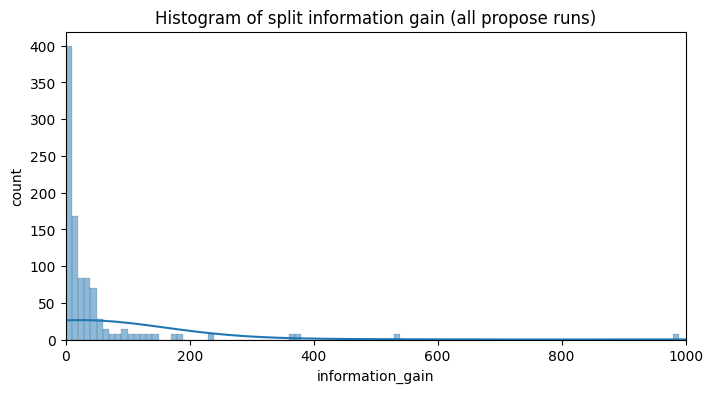

In [10]:
# Plot histogram of split information gain
if 'combined_logs_df' not in globals() or combined_logs_df.empty:
    print("No split logs available to plot.")
else:
    import matplotlib.pyplot as plt
    import seaborn as sns

    gains = combined_logs_df['information_gain'].dropna()
    plt.figure(figsize=(8, 4))
    sns.histplot(gains, bins=np.arange(0, 1000, 10), kde=True)
    plt.title("Histogram of split information gain (all propose runs)")
    plt.xlabel("information_gain")
    plt.ylabel("count")
    plt.xlim(0, 1000)
    plt.show()

In [11]:
combined_logs_df

,depth,information_gain,switched,delta,weighting_strategy,node_id,tree_index
0,0,5242.382150,False,0.001,propose,0,0
1,1,1374.329037,False,0.001,propose,1,0
2,2,370.407247,False,0.001,propose,2,0
3,2,366.824250,False,0.001,propose,5,0
4,1,982.703948,False,0.001,propose,8,0
...,...,...,...,...,...,...,...
975,2,17.947853,False,0.100,propose,2,19
976,2,3.380854,False,0.100,propose,5,19
977,1,0.439230,False,0.100,propose,8,19
978,2,0.908247,False,0.100,propose,9,19


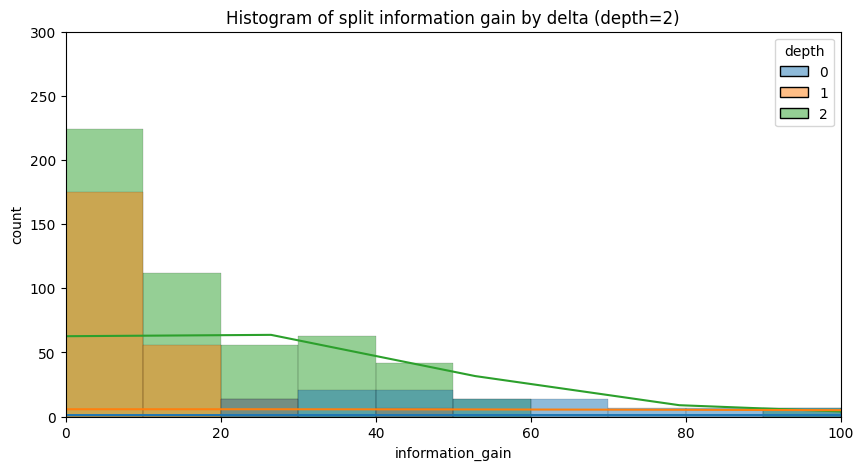

In [27]:
# Plot histogram of split information gain
if 'combined_logs_df' not in globals() or combined_logs_df.empty:
    print("No split logs available to plot.")
else:
    import matplotlib.pyplot as plt
    import seaborn as sns

    gains = combined_logs_df.dropna()
    # gains = gains[gains["depth"] == 2]
    # subset = gains[gains["delta"].isin([0, 1, 2, 3])]
    # if subset.empty:
    #     print("No depth==2 records for delta in {0,1,2,3}.")

    plt.figure(figsize=(10, 5))
    sns.histplot(
        data=gains,
        x="information_gain",
        hue="depth",
        bins=np.arange(0, 1000, 10),
        multiple="layer",
        kde=True,
        palette="tab10",
    )
    plt.title("Histogram of split information gain by delta (depth=2)")
    plt.xlabel("information_gain")
    plt.ylabel("count")
    plt.xlim(0, 100)
    plt.ylim(0, 300)
    plt.show()

### temp分析

In [5]:
combined_logs_df.head(10)

,depth,information_gain,switched,delta,weighting_strategy,node_id,tree_index
0,0,658.940975,False,0.0001,ctcvr_subctr_de_norm_gain,0,0
1,1,98.444061,False,0.0001,ctcvr_subctr_de_norm_gain,1,0
2,2,11.836097,False,0.0001,ctcvr_subctr_de_norm_gain,2,0
3,2,116.125109,False,0.0001,ctcvr_subctr_de_norm_gain,5,0
4,1,219.571990,False,0.0001,ctcvr_subctr_de_norm_gain,8,0
5,2,102.694264,False,0.0001,ctcvr_subctr_de_norm_gain,9,0
6,2,11.786897,True,0.0001,ctcvr_subctr_de_norm_gain,12,0
7,0,426.925847,False,0.0001,ctcvr_subctr_de_norm_gain,0,1
8,1,181.143129,False,0.0001,ctcvr_subctr_de_norm_gain,1,1
9,2,71.694119,False,0.0001,ctcvr_subctr_de_norm_gain,2,1


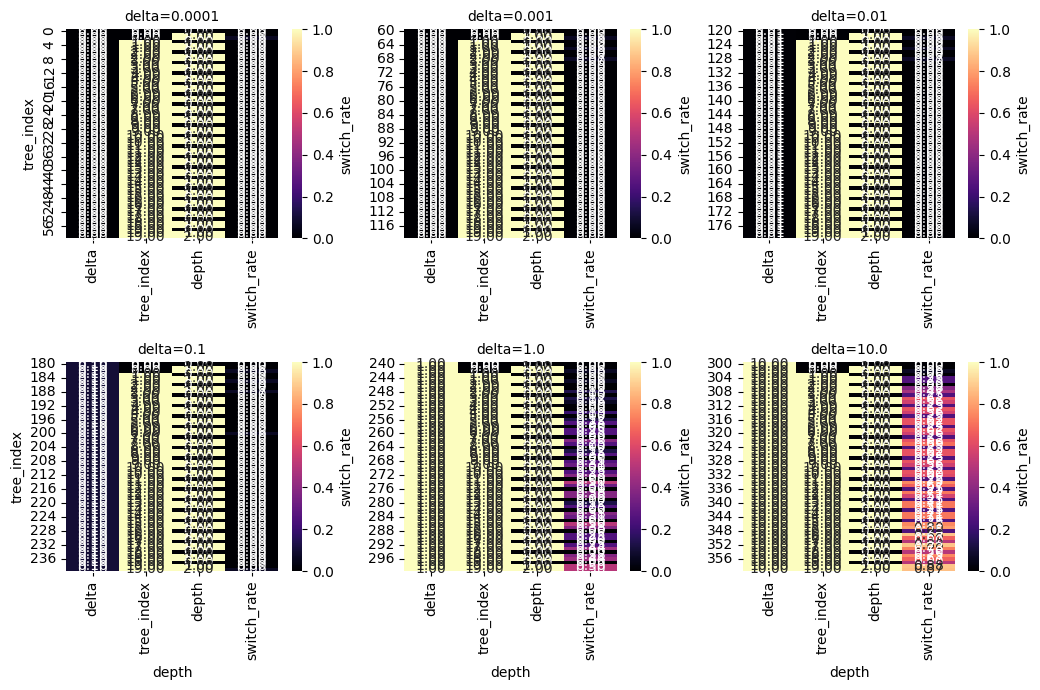

In [6]:
# switched rate (mean of `switched`) by depth and tree_index, faceted by delta
if 'combined_logs_df' not in globals() or combined_logs_df.empty:
    print("No split logs available to plot.")
else:
    import matplotlib.pyplot as plt
    import seaborn as sns

    df_sw = combined_logs_df.copy()
    df_sw['delta'] = pd.to_numeric(df_sw['delta'], errors='coerce')
    df_sw = df_sw.dropna(subset=['delta', 'depth', 'tree_index', 'switched'])

    # choose a few deltas to facet; adjust as needed
    deltas_to_show = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
    df_sw = df_sw[df_sw['delta'].isin(deltas_to_show)]

    grouped = (
        df_sw.groupby(['delta', 'tree_index', 'depth'])['switched']
        .mean()
        .reset_index(name='switch_rate')
    )

    g = sns.FacetGrid(grouped, col='delta', col_wrap=3, height=3.5, sharex=False, sharey=False)
    g.map_dataframe(
        sns.heatmap,
        data=lambda data: data.pivot_table(index='tree_index', columns='depth', values='switch_rate'),
        vmin=0,
        vmax=1,
        cmap='magma',
        cbar_kws={'label': 'switch_rate'},
        annot=True,
        fmt=".2f"
    )
    g.set_titles("delta={col_name}")
    g.set_axis_labels("depth", "tree_index")
    plt.tight_layout()
    plt.show()

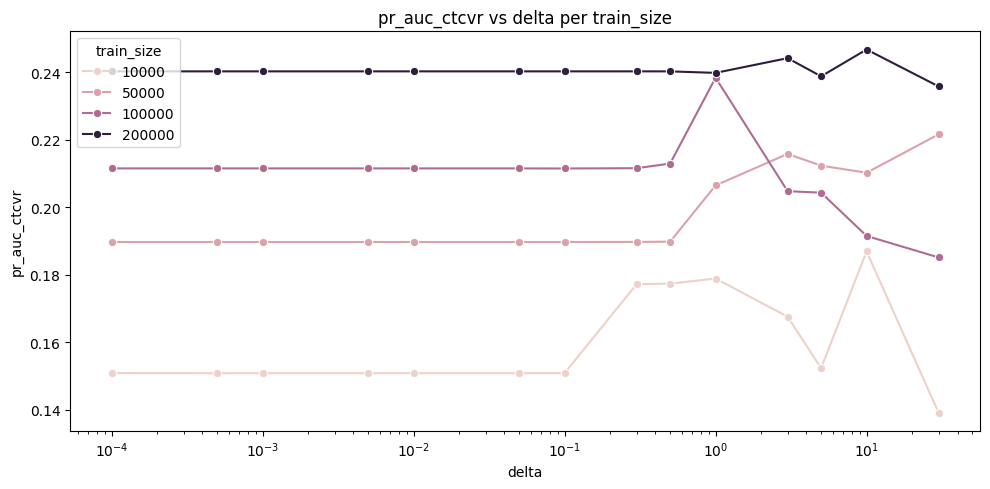

In [3]:
# pr_auc_ctcvr vs delta per train_size (added at notebook end)
if 'df_results' not in globals() or df_results.empty:
    print("df_results is empty. Run the experiment cells first.")
else:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    df_plot = df_results.copy()
    df_plot['delta'] = pd.to_numeric(df_plot['delta'], errors='coerce')
    df_plot = df_plot.dropna(subset=['delta', 'pr_auc_ctcvr'])
    
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_plot, x='delta', y='pr_auc_ctcvr', hue='train_size', marker='o')
    plt.title('pr_auc_ctcvr vs delta per train_size')
    plt.xlabel('delta')
    plt.ylabel('pr_auc_ctcvr')
    plt.xscale('log')
    plt.legend(title='train_size')
    plt.tight_layout()
    plt.show()

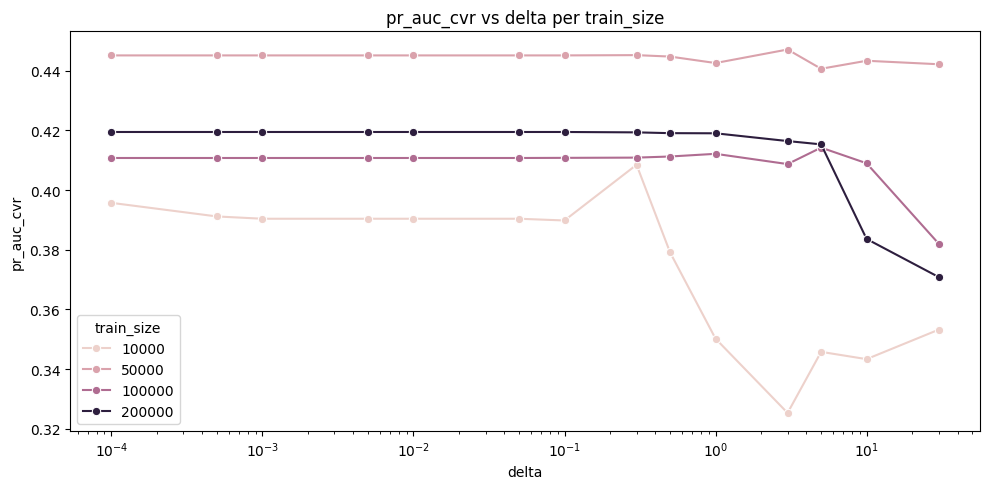

In [4]:
# pr_auc_cvr vs delta per train_size (added at notebook end)
if 'df_results' not in globals() or df_results.empty:
    print("df_results is empty. Run the experiment cells first.")
else:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    df_plot = df_results.copy()
    df_plot['delta'] = pd.to_numeric(df_plot['delta'], errors='coerce')
    df_plot = df_plot.dropna(subset=['delta', 'pr_auc_cvr'])
    
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_plot, x='delta', y='pr_auc_cvr', hue='train_size', marker='o')
    plt.title('pr_auc_cvr vs delta per train_size')
    plt.xlabel('delta')
    plt.ylabel('pr_auc_cvr')
    plt.xscale('log')
    plt.legend(title='train_size')
    plt.tight_layout()
    plt.show()

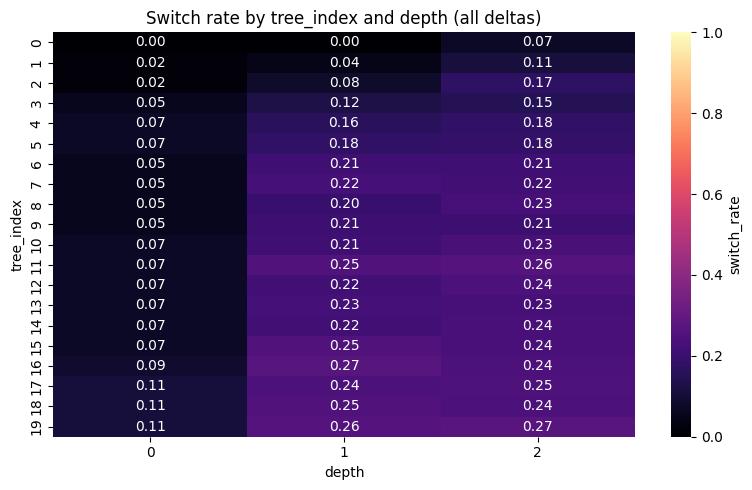

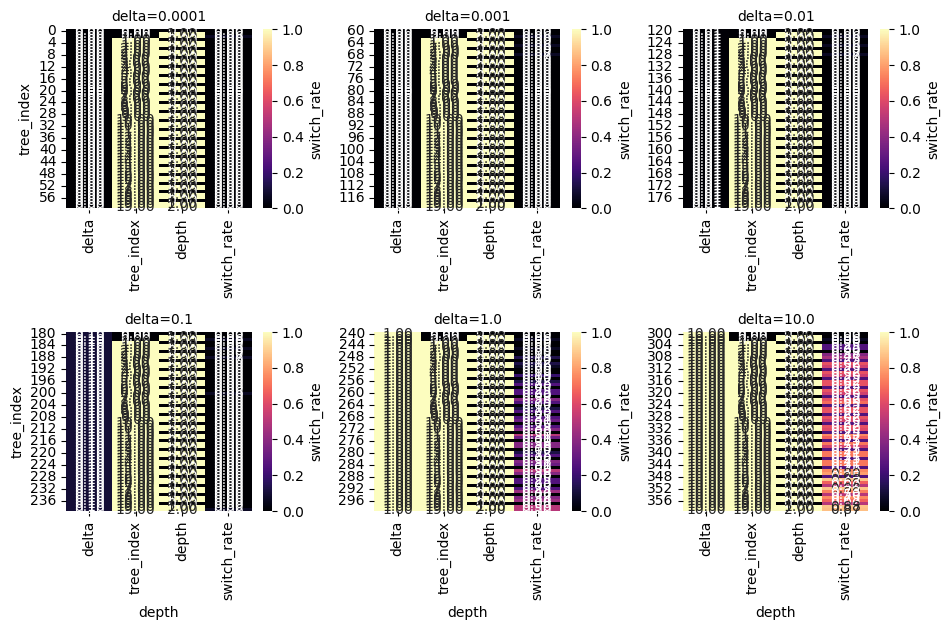

In [7]:
# switched rate heatmap by depth and tree_index
if 'combined_logs_df' not in globals() or combined_logs_df.empty:
    print("No split logs available to plot.")
else:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    df_sw = combined_logs_df.copy()
    df_sw['delta'] = pd.to_numeric(df_sw.get('delta'), errors='coerce')
    df_sw['depth'] = pd.to_numeric(df_sw.get('depth'), errors='coerce')
    df_sw['tree_index'] = pd.to_numeric(df_sw.get('tree_index'), errors='coerce')
    df_sw['switched'] = df_sw['switched'].astype(float)
    df_sw = df_sw.dropna(subset=['depth', 'tree_index', 'switched'])
    
    # overall heatmap: switch rate aggregated over all deltas
    overall = (
        df_sw.groupby(['tree_index', 'depth'])['switched']
        .mean()
        .reset_index(name='switch_rate')
    )
    pivot = overall.pivot(index='tree_index', columns='depth', values='switch_rate')
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, vmin=0, vmax=1, cmap='magma', annot=True, fmt='.2f', cbar_kws={'label': 'switch_rate'})
    plt.title('Switch rate by tree_index and depth (all deltas)')
    plt.xlabel('depth')
    plt.ylabel('tree_index')
    plt.tight_layout()
    plt.show()
    
    # optional: facet by selected deltas if present
    deltas_to_show = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
    df_facet = df_sw[df_sw['delta'].isin(deltas_to_show)]
    if not df_facet.empty:
        grouped = (
            df_facet.groupby(['delta', 'tree_index', 'depth'])['switched']
            .mean()
            .reset_index(name='switch_rate')
        )
        g = sns.FacetGrid(grouped, col='delta', col_wrap=3, height=3.2, sharex=False, sharey=False)
        g.map_dataframe(
            sns.heatmap,
            data=lambda data: data.pivot_table(index='tree_index', columns='depth', values='switch_rate'),
            vmin=0,
            vmax=1,
            cmap='magma',
            cbar_kws={'label': 'switch_rate'},
            annot=True,
            fmt='.2f'
        )
        g.set_titles('delta={col_name}')
        g.set_axis_labels('depth', 'tree_index')
        plt.tight_layout()
        plt.show()
    else:
        print('Facet plot skipped: no rows for selected deltas.')

## その他

In [1]:
import numpy as np
from scipy.optimize import minimize

# --- 1. 定義 ---
def f(x):
    """目的関数"""
    return x[0]**2 + x[1]**2

def g(x):
    """等式制約: x1 - 3x2 - 6 = 0"""
    return x[0] - 3*x[1] - 6

def augmented_lagrangian(x, y, rho):
    """拡張ラグランジュ関数 L_rho(x, y)"""
    constraint_val = g(x)
    return f(x) + y * constraint_val + (rho / 2.0) * (constraint_val**2)

# --- 追加: 勾配とヘッセ行列の関数 ---
def grad_augmented_lagrangian(x, y, rho):
    """L_rho の勾配ベクトル (Jacobian)"""
    gx = g(x)
    # dL/dx1
    dL_dx1 = 2*x[0] + y + rho * gx * 1.0
    # dL/dx2
    dL_dx2 = 2*x[1] - 3*y + rho * gx * (-3.0)
    return np.array([dL_dx1, dL_dx2])

def hess_augmented_lagrangian(x, y, rho):
    """L_rho のヘッセ行列 (Hessian)"""
    # 2階微分は定数となる
    H11 = 2.0 + rho
    H12 = -3.0 * rho
    H22 = 2.0 + 9.0 * rho
    return np.array([[H11, H12], [H12, H22]])

# --- 2. パラメータ設定 ---
x_k = np.array([2.0, 2.0])
y_k = 0.0
rho_k = 1.0
rho_update_rate = 2.0
tolerance = 1e-6
max_iter = 100

print(f"{'Iter':<5} {'x1':<10} {'x2':<10} {'y':<10} {'rho':<10} {'Constraint Error':<25}")
print("-" * 75)

# --- 3. メインアルゴリズム ---
for k in range(max_iter):
    # 制約違反の確認
    constraint_violation = g(x_k)**2
    
    print(f"{k:<5} {x_k[0]:<10.5f} {x_k[1]:<10.5f} {y_k:<10.5f} {rho_k:<10.5f} {constraint_violation:<25.8e}")

    if constraint_violation < tolerance:
        print("-" * 75)
        print(f"Converged at iteration {k}!")
        break

    # --- STEP 3: 制約なし最適化 (ニュートン法) ---

    res = minimize(
        fun=augmented_lagrangian,
        x0=x_k,
        args=(y_k, rho_k),
        method='Newton-CG',             
        jac=grad_augmented_lagrangian,  
        hess=hess_augmented_lagrangian  
    )
    
    x_next = res.x

    # --- STEP 4: パラメータ更新 ---
    y_next = y_k + rho_k * g(x_next)
    rho_next = rho_update_rate * rho_k

    x_k = x_next
    y_k = y_next
    rho_k = rho_next

# --- 結果の確認 ---
print("\n=== Final Result ===")
print(f"Optimal Solution x*: {x_k}")
print(f"Optimal Value f(x*): {f(x_k)}")
print(f"Lagrange Multiplier y*: {y_k}")

Iter  x1         x2         y          rho        Constraint Error         
---------------------------------------------------------------------------
0     2.00000    2.00000    0.00000    1.00000    1.00000000e+02           
1     0.50000    -1.50000   -1.00000   2.00000    1.00000000e+00           
2     0.59091    -1.77273   -1.18182   4.00000    8.26446281e-03           
3     0.59957    -1.79870   -1.19913   8.00000    1.87402785e-05           
4     0.59999    -1.79997   -1.19998   16.00000   1.11482918e-08           
---------------------------------------------------------------------------
Converged at iteration 4!

=== Final Result ===
Optimal Solution x*: [ 0.59998944 -1.79996832]
Optimal Value f(x*): 3.5998732985491015
Lagrange Multiplier y*: -1.199978882905718


In [7]:
# Export 500k rows from PCB zip TSV to CSV in the same directory
from pathlib import Path
import pandas as pd


def export_pcb_sample(n_rows: int = 500_000,
                      zip_path: Path | str = "C:\\Users\\oiwal\\products\\MT_AI_GBDT\\src\\data\\pcb_dataset_final.tsv.zip",
                      output_path: Path | str | None = None) -> Path:
    """Load up to `n_rows` from the PCB TSV zip and save as CSV next to the zip.

    The function mirrors PCBDataset defaults: reads the zip TSV, limits rows for memory,
    and writes a CSV sibling file for quicker reuse.
    """
    zip_path = Path(zip_path)
    if output_path is None:
        output_path = zip_path.with_name(f"{zip_path.stem}_sample{n_rows}.csv")
    output_path = Path(output_path)

    if not zip_path.exists():
        raise FileNotFoundError(f"PCB dataset not found: {zip_path}")

    print(f"Reading up to {n_rows:,} rows from {zip_path} ...")
    df = pd.read_csv(zip_path, sep="\t", compression="zip", nrows=n_rows)

    print(f"Saving {len(df):,} rows to {output_path} ...")
    output_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(output_path, index=False)
    print("Done.")
    return output_path


# Example: export_pcb_sample()  # uncomment to run

In [8]:
export_pcb_sample()

Reading up to 500,000 rows from C:\Users\oiwal\products\MT_AI_GBDT\src\data\pcb_dataset_final.tsv.zip ...
Saving 500,000 rows to C:\Users\oiwal\products\MT_AI_GBDT\src\data\pcb_dataset_final.tsv_sample500000.csv ...
Done.


WindowsPath('C:/Users/oiwal/products/MT_AI_GBDT/src/data/pcb_dataset_final.tsv_sample500000.csv')